# Human hematopoesis benchmark

## Library imports

In [ ]:
import os
import sys
from collections import Counter
from itertools import chain, product
from pathlib import Path
from typing import Dict, List, Literal, Optional, Union

import regvelo

In [1]:
from paths import DATA_DIR, FIG_DIR
from regvelo import REGVELOVI

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
import torch
from velovi import VELOVI

sys.path.append("../..")

2024-08-21 01:12:38.766896: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 01:12:43.101376: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 01:12:43.101801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 01:12:43.106994: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 01:12:44.423694: I tensorflow/core/platform/cpu_feature_g

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "hematopoiesis", exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / "hematopoiesis", exist_ok=True)

## Function defination

In [4]:
def get_var_ranks(
    var_names: List[str], drivers: pd.DataFrame, macrostate: str, var_type: str, model: str, threshold: int = 100
):
    """TODO."""
    """Get ranking of a set of variables towards a given macrostate."""
    _df = drivers.loc[
        var_names, [f"{macrostate}_corr", f"{macrostate}_pval", f"Corr. rank - {macrostate}"]
    ].sort_values(by=[f"Corr. rank - {macrostate}"])

    _df["Type"] = var_type
    _df["Algorithm"] = model

    print(
        f"{var_type} towards {macrostate} for {model} in top {threshold}: "
        f"{(_df[f'Corr. rank - {macrostate}'] <= threshold).sum()} (out of {_df.shape[0]})"
    )

    return _df


def add_regvelo_outputs_to_adata(adata_raw, vae):
    """TODO."""
    latent_time = vae.get_latent_time(n_samples=30, batch_size=adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, batch_size=adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:, vae.module.target_index].copy()

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time

    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0

    return adata


def add_outputs_to_adata(adata, vae):
    """TODO."""
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr).detach().cpu().numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0


def plot_states(
    adata,
    estimator,
    figsize,
    which: Literal["macrostates", "terminal_states"],
    basis: str,
    inplace: bool = False,
    fpath: Optional[str] = None,
    format: str = "png",
    dpi: Union[int, str] = "figure",
    **kwargs,
):
    """TODO."""
    if not inplace:
        adata = adata.copy()

    states = getattr(estimator, which).cat.categories.tolist()
    if which == "macrostates":
        states = estimator._macrostates
    elif which == "terminal_states":
        states = estimator._term_states
    state_names = states.assignment.cat.categories.tolist()

    adata.obs[which] = states.assignment.astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)
    if which == "macrostates":
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors
    else:
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors.tolist()
    fig, ax = plt.subplots(figsize=figsize)
    scv.pl.scatter(
        adata,
        basis=basis,
        c=which,
        add_outline=state_names,
        ax=ax,
        **kwargs,
    )
    # plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.42), ncol=2,frameon=False)

    if fpath is not None:
        fig.savefig(fpath, format=format, transparent=True, bbox_inches="tight", dpi=dpi)

In [5]:
def prior_GRN(adata, gt_net):
    """TODO."""
    ## filter low co-expressed GRN
    regulator_index = [i in gt_net.columns for i in adata.var.index.values]
    target_index = [i in gt_net.index for i in adata.var.index.values]

    corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric="correlation")
    corr_m = torch.tensor(corr_m)
    corr_m = corr_m[target_index,]
    corr_m = corr_m[:, regulator_index]
    corr_m = corr_m.float()

    corr_m[np.isnan(corr_m)] = 0
    corr_m = pd.DataFrame(
        corr_m, index=adata.var.index.values[target_index], columns=adata.var.index.values[regulator_index]
    )
    gt_net = gt_net.loc[corr_m.index, corr_m.columns]
    GRN_final = gt_net * corr_m

    GRN_final[abs(GRN_final) < 0.01] = 0
    GRN_final[GRN_final != 0] = 1
    for i in GRN_final.columns:
        GRN_final.loc[i, i] = 0
    GRN_final = GRN_final.iloc[(GRN_final.sum(1) > 0).tolist(), (GRN_final.sum(0) > 0).tolist()]
    genes = np.unique(GRN_final.index.tolist() + GRN_final.columns.tolist())
    W = torch.zeros((len(genes), len(genes)))
    W = pd.DataFrame(W, index=genes, columns=genes)
    W.loc[GRN_final.columns.tolist(), GRN_final.index.tolist()] = GRN_final.T

    reg_bdata = adata[:, W.index].copy()

    W = W.loc[reg_bdata.var.index.values.tolist(), reg_bdata.var.index.values.tolist()]
    W = torch.tensor(np.array(W))
    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    list(set(reg_bdata.uns["regulators"]).intersection(reg_bdata.uns["targets"]))

    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    reg_bdata.uns["skeleton"] = np.array(W)
    reg_bdata.uns["network"] = np.ones((len(reg_bdata.var.index), len(reg_bdata.var.index)))

    return reg_bdata

In [6]:
def get_significance(pvalue) -> str:
    """TODO."""
    """Assign significance symbol based on p-value."""
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [7]:
def get_optimal_auc(n_vars):
    """TODO."""
    """Compute AUC if given all genes are ranked first."""
    return n_vars * (n_vars + 1) / 2 + (914 - n_vars) * n_vars


def plot_method_comparison(gene_ranks, method_pairs, terminal_state, criteria):
    """TODO."""
    """Plot performance of each method w.r.t. gene ranking."""
    n_cols = len(method_pairs)
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6 * n_cols, 6), ncols=n_cols)

        for ax_id, methods in enumerate(method_pairs):
            method_a, method_b = methods
            _df = gene_ranks[terminal_state]

            ranks_a = _df.loc[_df["Algorithm"] == method_a].set_index("NAME")
            ranks_b = _df.loc[_df["Algorithm"] == method_b].set_index("NAME")

            ranks_a, ranks_b = ranks_a.align(ranks_b)

            df = pd.DataFrame(
                {
                    f"{method_a}": ranks_a[criteria],
                    f"{method_b}": ranks_b[criteria],
                }
            )
            a_better_b = (ranks_a[criteria] < ranks_b[criteria]).sum() / ranks_a[criteria].size * 100

            sns.scatterplot(data=df, x=method_a, y=method_b, ax=ax[ax_id])

            lims = [
                np.min([ax[ax_id].get_xlim(), ax[ax_id].get_ylim()]),  # min of both axes
                np.max([ax[ax_id].get_xlim(), ax[ax_id].get_ylim()]),  # max of both axes
            ]

            # now plot both limits against eachother
            ax[ax_id].plot(lims, lims, "k-", alpha=0.75, zorder=0)
            ax[ax_id].set_aspect("equal")
            ax[ax_id].set_xlim(lims)
            ax[ax_id].set_ylim(lims)

            ax[ax_id].set_title(f'"{method_a}" < "{method_b}": {a_better_b:.2f}%')

        plt.tight_layout()
        plt.show()


def get_gene_ranks():
    """TODO."""
    """Loads gene ranking of each method."""
    gene_ranks = {}
    for terminal_state in TERMINAL_STATES:
        # If Dynamo is included: [[f"Corr. rank - {terminal_state}", "Algorithm", "Run"]].fillna(0)
        gene_ranks[terminal_state] = (
            pd.concat(
                [
                    pd.read_csv(Path("results2") / f"gene_ranks_{terminal_state}-rgvelo.csv"),
                    pd.read_csv(Path("results2") / f"gene_ranks_{terminal_state}-scVelo.csv"),
                    pd.read_csv(Path("results2") / f"gene_ranks_{terminal_state}-veloVI.csv"),
                ]
            )
            .rename(columns={"Unnamed: 0": "Gene"})
            .drop_duplicates(subset=["Gene", "Algorithm"])[["Gene", f"Corr. rank - {terminal_state}", "Algorithm"]]
        )

        # gene_ranks[terminal_state].replace({"EM Model": "scVelo"}, inplace=True)
        gene_ranks[terminal_state].replace(
            {"RegVelo", "scVelo", "veloVI"},
            inplace=True,
        )

        # Random rank assignment
        np.random.seed(0)
        var_names = (
            gene_ranks[terminal_state].loc[gene_ranks[terminal_state]["Algorithm"] == "RegVelo", "Gene"].unique()
        )
        random_ranking = pd.DataFrame(
            {
                "Gene": var_names,
                f"Corr. rank - {terminal_state}": np.random.choice(np.arange(914), size=len(var_names), replace=False),
                "Algorithm": "Random assignment",
            }
        )

        # Optimal gene ranking
        optimal_ranking = pd.DataFrame(
            {
                "Gene": var_names,
                f"Corr. rank - {terminal_state}": np.arange(len(var_names)),
                "Algorithm": "Optimal assignment",
            }
        )
        gene_ranks[terminal_state] = pd.concat([gene_ranks[terminal_state], random_ranking, optimal_ranking])
    return gene_ranks


def get_rank_threshold(gene_ranks, n_methods):
    """TODO."""
    """Computes number of genes ranked below a given threshold for each method."""
    rank_threshold = np.arange(0, 914)
    dfs = {}

    for terminal_state in TERMINAL_STATES:
        col_name = f"Corr. rank - {terminal_state}"

        if "Run" in gene_ranks[terminal_state].columns:
            dfs[terminal_state] = pd.DataFrame(
                gene_ranks[terminal_state]
                .groupby(["Algorithm", "Run"])
                .apply(lambda x: (x[col_name].values < rank_threshold.reshape(-1, 1)).sum(axis=1))  # noqa: B023
                .to_dict()
            )
            dfs[terminal_state] = pd.melt(dfs[terminal_state]).rename(
                {"variable_0": "Algorithm", "variable_1": "Run", "value": "Rank CDF"}, axis=1
            )
            dfs[terminal_state]["Rank threshold"] = np.concatenate([rank_threshold] * n_methods[terminal_state])
        else:
            dfs[terminal_state] = pd.DataFrame(
                gene_ranks[terminal_state]
                .groupby(["Algorithm"])
                .apply(lambda x: (x[col_name].values < rank_threshold.reshape(-1, 1)).sum(axis=1))  # noqa: B023
                .to_dict()
            )
            dfs[terminal_state] = pd.melt(dfs[terminal_state]).rename(
                {"variable": "Algorithm", "value": "Rank CDF"}, axis=1
            )
            dfs[terminal_state]["Rank threshold"] = np.concatenate([rank_threshold] * n_methods[terminal_state])
    return dfs


def plot_gene_ranking(rank_threshold, methods, path, format, fname: str = "", palette: Optional[Dict[str, str]] = None):
    """TODO."""
    """Plots number of ranked genes below a specified threshold."""
    _n_methods = list(map(len, methods.values()))
    _argmax_n_methods = np.argmax(_n_methods)
    _methods = list(methods.values())[_argmax_n_methods]
    _n_methods = _n_methods[_argmax_n_methods]

    if palette is None:
        palette = dict(zip(_methods, sns.color_palette("colorblind").as_hex()[:_n_methods]))
        palette["Optimal assignment"] = "#000000"

    with mplscience.style_context():
        sns.set_style(style="whitegrid")

        fig, ax = plt.subplots(figsize=(6 * len(TERMINAL_STATES), 4), ncols=len(TERMINAL_STATES))

        for ax_id, terminal_state in enumerate(TERMINAL_STATES):
            _df = rank_threshold[terminal_state]
            _df["line_style"] = "-"
            _df.loc[_df["Algorithm"] == "Optimal assignment", "line_style"] = "--"

            sns.lineplot(
                data=_df,
                x="Rank threshold",
                y="Rank CDF",
                hue="Algorithm",
                style="Algorithm",
                dashes={
                    "Optimal assignment": (2, 2),
                    "Random assignment": "",
                    "RegVelo": "",
                    "veloVI": "",
                    "scVelo": "",
                },
                palette=palette,
                ax=ax[ax_id],
            )
            ax[ax_id].set_title(terminal_state)
            if ax_id == 0:
                handles, labels = ax[ax_id].get_legend_handles_labels()
                # handles[3].set_linestyle("--")
            ax[ax_id].get_legend().remove()

        handles = [handles[0], handles[1], handles[2], handles[3], handles[4]]
        labels = [labels[0], labels[1], labels[2], labels[3], labels[4]]
        fig.legend(handles=handles[:6], labels=labels[:6], loc="lower center", ncol=6, bbox_to_anchor=(0.5, -0.05))
        plt.tight_layout()
        plt.show()
        fig.savefig(path, format=format)


def get_aucs(gene_ranking_dfs, optimal_aucs, methods):
    """TODO."""
    """Computes area under the ranking threshold curve."""
    all_methods = list(set(chain(*methods.values())))

    # Absolute AUC
    auc_df = pd.DataFrame(index=all_methods, columns=TERMINAL_STATES, dtype=float)

    # Given AUC w.r.t. optimal AUC
    auc_rel_df = pd.DataFrame(index=all_methods, columns=TERMINAL_STATES, dtype=float)

    rank_threshold = np.arange(0, 914)
    aucs_ = {terminal_state: {} for terminal_state in TERMINAL_STATES}
    for method, terminal_state in product(all_methods, TERMINAL_STATES):
        _df = gene_ranking_dfs[terminal_state]
        if (method == "Dynamo") and _df["Algorithm"].isin([method]).any():
            aucs_[terminal_state][method] = [
                auc(x=rank_threshold, y=_df.loc[(_df["Algorithm"] == method) & (_df["Run"] == run), "Rank CDF"].values)
                for run in _df["Run"].unique()
            ]
            auc_df.loc[method, terminal_state] = np.mean(aucs_[terminal_state][method])
            auc_rel_df.loc[method, terminal_state] = (
                auc_df.loc[method, terminal_state] / optimal_aucs[terminal_state].loc[method]
            )
        elif method == "Dynamo":
            pass
        else:
            aucs_[terminal_state][method] = auc(
                x=rank_threshold, y=_df.loc[_df["Algorithm"] == method, "Rank CDF"].values
            )
            auc_df.loc[method, terminal_state] = aucs_[terminal_state][method]
            auc_rel_df.loc[method, terminal_state] = (
                auc_df.loc[method, terminal_state] / optimal_aucs[terminal_state].loc[method]
            )
    return auc_df, auc_rel_df

## Load dataset

In [8]:
adata = sc.read_h5ad("RegVelo_datasets/hematopoiesis/hsc_dynamo_adata.h5ad")
TF = pd.read_csv("RegVelo_datasets/hematopoiesis/allTFs_hg38.csv", header=None)
gt_net = pd.read_csv("RegVelo_datasets/hematopoiesis/skeleton.csv", index_col=0)

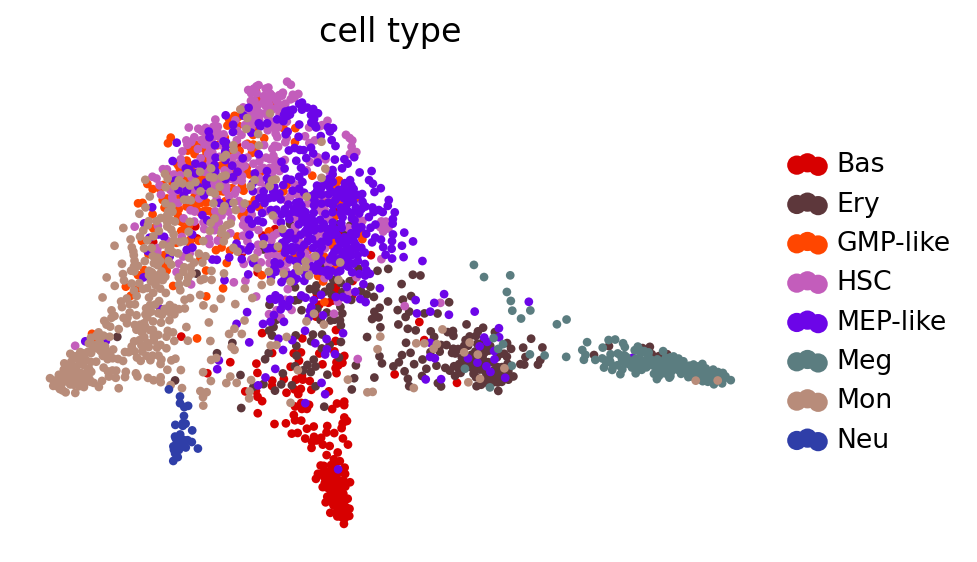

In [9]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.scatter(adata, basis="draw_graph_fa", color="cell_type", frameon=False, ax=ax)

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "hematopoiesis" / "intro_figure.svg", format="svg", transparent=True, bbox_inches="tight")

### Preprocessing

In [10]:
scv.pp.filter_and_normalize(adata, min_shared_counts=10, n_top_genes=2000)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 17891 genes that are detected 10 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Import prior gene regulatory graph

In [11]:
reg_bdata = prior_GRN(adata, gt_net)
adata_full = reg_bdata.copy()

/tmp/ipykernel_548485/2195261365.py:12: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1646.)
  corr_m[np.isnan(corr_m)] = 0


In [12]:
adata_full.shape

(1947, 914)

In [13]:
## Apply steady state mode
scv.tl.velocity(reg_bdata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## RegVelo preprocessing

In [14]:
TF_GRN = reg_bdata.var_names[reg_bdata.uns["skeleton"].T.sum(0) != 0].tolist()
TF = list(set(TF.iloc[:, 0].tolist()).intersection(TF_GRN))

In [15]:
reg_bdata.var["TF"] = [i in TF for i in reg_bdata.var_names]
reg_bdata = reg_bdata[
    :,
    np.unique(
        reg_bdata.var_names[reg_bdata.var["TF"]].tolist()
        + reg_bdata.var_names[reg_bdata.var["velocity_r2"] > 0].tolist()
    ),
].copy()

In [16]:
reg_bdata = regvelo.preprocess_data(reg_bdata)

In [17]:
gene_name = reg_bdata.var.index.tolist()
full_name = reg_bdata.uns["regulators"]
index = [i in gene_name for i in full_name]
full_name = full_name[index]
reg_bdata = reg_bdata[:, full_name].copy()

W = reg_bdata.uns["skeleton"]
W = W[index, :]
W = W[:, index]
reg_bdata.uns["skeleton"] = W
reg_bdata.uns["regulators"] = np.array(gene_name)
reg_bdata.uns["targets"] = np.array(gene_name)

## Run veloVI and scVelo

In [18]:
## scVelo
adata_scv = reg_bdata.copy()
scv.tl.recover_dynamics(adata_scv, fit_scaling=False, var_names=adata_scv.var_names)
adata_scv.var["fit_scaling"] = 1.0
scv.tl.velocity(adata_scv, mode="dynamical", min_likelihood=-np.inf, min_r2=None)
adata_scv.var["velocity_genes"] = reg_bdata.var["velocity_genes"].copy()

recovering dynamics (using 1/64 cores)


  0%|          | 0/158 [00:00<?, ?gene/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [19]:
adata_vi = reg_bdata.copy()
VELOVI.setup_anndata(adata_vi, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata_vi)
vae.train()

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 444/500:  89%|████████▉ | 444/500 [00:56<00:07,  7.87it/s, loss=-276, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -261.491. Signaling Trainer to stop.


## Run RegVelo (regularized)

In [20]:
W = reg_bdata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [21]:
REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(reg_bdata, W=W.T, regulators=TF, lam2=1)

In [22]:
reg_vae.train()

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1012/1500:  67%|██████▋   | 1012/1500 [05:34<02:41,  3.03it/s, loss=-202, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -323.313. Signaling Trainer to stop.


## Run RegVelo

In [23]:
W = reg_bdata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [24]:
REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae_raw = REGVELOVI(reg_bdata, W=W.T, regulators=TF)

In [25]:
reg_vae_raw.train()

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1031/1500:  69%|██████▊   | 1031/1500 [05:44<02:36,  2.99it/s, loss=-244, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -357.616. Signaling Trainer to stop.


## Terminal state identification

In [26]:
my_list = reg_bdata.obs["cell_type"].tolist()
summary = dict(Counter(my_list))
print(summary)

{'Mon': 423, 'Meg': 154, 'MEP-like': 457, 'Ery': 234, 'Bas': 177, 'GMP-like': 161, 'HSC': 309, 'Neu': 32}


In [27]:
terminal_states = ["Meg", "Mon", "Ery", "Bas", "Neu"]

all_states = list(set(reg_bdata.obs["cell_type"].tolist()))

all_id = all_states.copy()
all_type = all_states.copy()
for i in all_states:
    for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        all_id.append(i + "_" + str(j))
        all_type.append(i)
all_dict = dict(zip(all_id, all_type))

In [28]:
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)
scv.tl.velocity_graph(adata_target)
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)

computing velocity graph (using 1/64 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

In [29]:
n_states = 6
g.compute_macrostates(n_states=n_states, cluster_key="cell_type", n_cells=10)

GPCCA[kernel=(0.8 * VelocityKernel[n=1947] + 0.2 * ConnectivityKernel[n=1947]), initial_states=None, terminal_states=None]

In [30]:
g.set_terminal_states(terminal_states, n_cells=10)

GPCCA[kernel=(0.8 * VelocityKernel[n=1947] + 0.2 * ConnectivityKernel[n=1947]), initial_states=None, terminal_states=['Bas', 'Ery', 'Meg', 'Mon', 'Neu']]

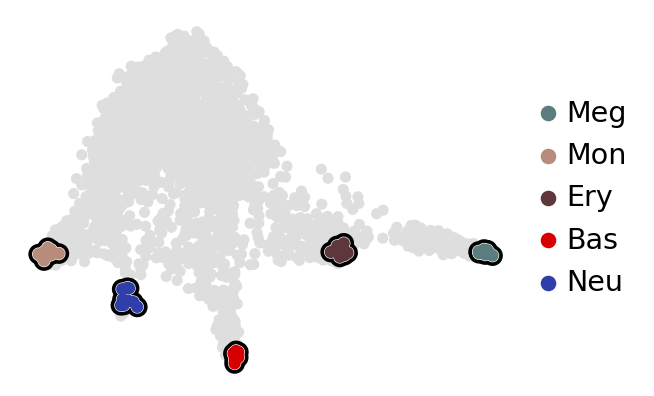

In [31]:
if SAVE_FIGURES:
    plot_states(
        adata_target,
        estimator=g,
        figsize=(4, 3),
        which="terminal_states",
        basis="draw_graph_fa",
        legend_loc="right",
        title="",
        size=100,
        dpi=400,
        format="svg",
        fpath=FIG_DIR / "hematopoiesis" / "terminal_state.svg",
    )

## Uncertainty prediction

In [32]:
uncertainty_df_vi, _ = vae.get_directional_uncertainty(n_samples=30)

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Plea

In [33]:
adata_vi.obs["veloVI intrinsic uncertainty"] = np.log10(uncertainty_df_vi["directional_cosine_sim_variance"].values)

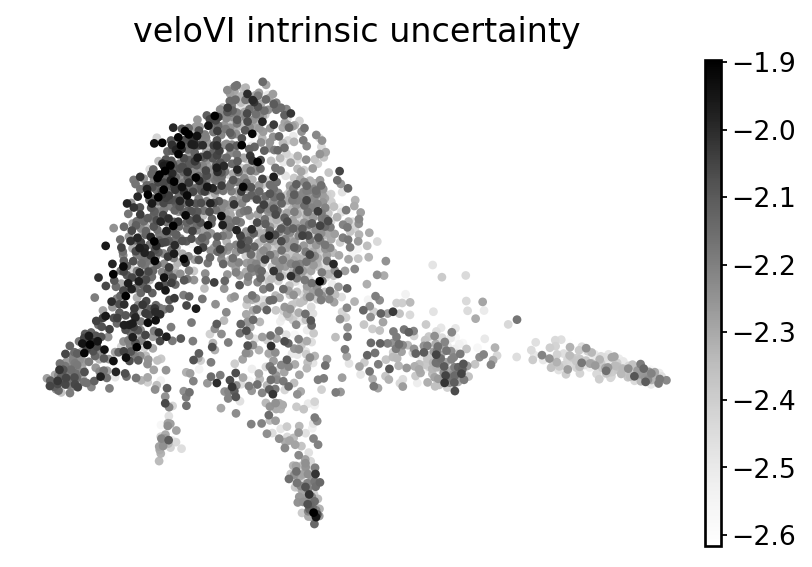

In [34]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.embedding(
        adata_vi,
        color="veloVI intrinsic uncertainty",
        cmap="Greys",
        basis="draw_graph_fa",
        vmin="p1",
        vmax="p99",
        ax=ax,
        frameon=False,
    )

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "hematopoiesis" / "vi_uncertainty.svg", format="svg", transparent=True, bbox_inches="tight")

In [35]:
uncertainty_df, _ = reg_vae.get_directional_uncertainty(n_samples=30)

INFO     regvelovi: Sampling from model...                                                                         
INFO     regvelovi: Computing the uncertainties...                                                                 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1900 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1947 out of 1947 | elapsed:    3.4s finished


In [36]:
adata_target.obs["RegVelo intrinsic uncertainty"] = np.log10(uncertainty_df["directional_cosine_sim_variance"].values)

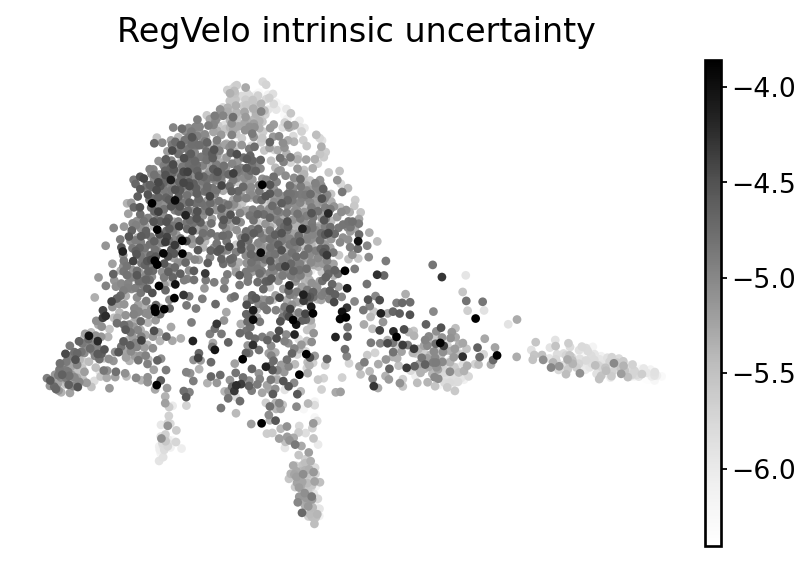

In [37]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.embedding(
        adata_target,
        color="RegVelo intrinsic uncertainty",
        cmap="Greys",
        basis="draw_graph_fa",
        vmin="p1",
        vmax="p99",
        ax=ax,
        frameon=False,
    )

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "hematopoiesis" / "rgv_uncertainty.svg", format="svg", transparent=True, bbox_inches="tight")

In [38]:
regvi_score = uncertainty_df["directional_cosine_sim_variance"].values / np.mean(
    uncertainty_df["directional_cosine_sim_variance"].values[
        adata_target.obs["cell_type"].isin(["MEP-like", "GMP-like"])
    ]
)
vi_score = uncertainty_df_vi["directional_cosine_sim_variance"].values / np.mean(
    uncertainty_df_vi["directional_cosine_sim_variance"].values[
        adata_target.obs["cell_type"].isin(["MEP-like", "GMP-like"])
    ]
)

In [39]:
palette2 = []
for ct in terminal_states:
    data = np.log10(vi_score[g.terminal_states == ct] / regvi_score[g.terminal_states == ct])
    # Step 2: Perform a one-sample t-test to compare the mean to a threshold value (e.g., 5)
    threshold = 0
    b = np.zeros(len(data))
    t_stat, p_value = wilcoxon(data, b, alternative="greater")
    significance = get_significance(p_value)

    significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}
    palette2.append(significance_palette[significance])

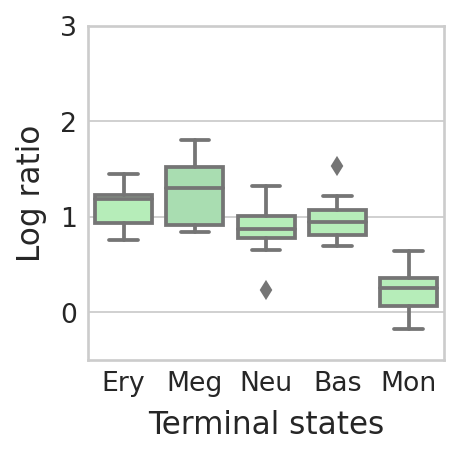

In [40]:
scores = {
    "Ery": np.log10(vi_score[g.terminal_states == "Ery"] / regvi_score[g.terminal_states == "Ery"]),
    "Meg": np.log10(vi_score[g.terminal_states == "Meg"] / regvi_score[g.terminal_states == "Meg"]),
    "Neu": np.log10(vi_score[g.terminal_states == "Neu"] / regvi_score[g.terminal_states == "Neu"]),
    "Bas": np.log10(vi_score[g.terminal_states == "Bas"] / regvi_score[g.terminal_states == "Bas"]),
    "Mon": np.log10(vi_score[g.terminal_states == "Mon"] / regvi_score[g.terminal_states == "Mon"]),
}

# Combine into a DataFrame
df = pd.DataFrame(scores)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = plt.subplots(figsize=(3, 3))

    # Step 4: Color based on significance

    sns.boxplot(data=df, palette=palette2)

    # Add titles and labels
    plt.ylim(-0.5, 3)
    plt.xlabel("Terminal states")
    plt.ylabel("Log ratio")

    fig.tight_layout()
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "terminal_states_noise_ratio.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Predicting drivers

### driver prediction using RegVelo

In [41]:
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()
g = cr.estimators.GPCCA(vk)

g.compute_macrostates(n_states=5, cluster_key="cell_type")

terminal_states = [
    "Mon",
    "Meg",
    "Bas",
    "Ery",
]
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
g.adata = adata_full.copy()
drivers_rgv = g.compute_lineage_drivers(return_drivers=True, cluster_key="cell_type")

drivers_rgv = drivers_rgv.loc[:, ["Ery_corr", "Mon_corr", "Ery_pval", "Mon_pval"]]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/4 [00:00<?, ?/s]

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `Lengths must match to compare`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [42]:
# del adata_scv.var["velocity_genes"]
vk = cr.kernels.VelocityKernel(adata_scv)
vk.compute_transition_matrix()
g2 = cr.estimators.GPCCA(vk)

g2.compute_macrostates(n_states=5, cluster_key="cell_type")

terminal_states = [
    "Mon",
    "Meg",
    "Bas",
    "Ery",
]
g2.set_terminal_states(terminal_states)
g2.compute_fate_probabilities()
g2.adata = adata_full.copy()
drivers_scv = g2.compute_lineage_drivers(return_drivers=True, cluster_key="cell_type")

drivers_scv = drivers_scv.loc[:, ["Ery_corr", "Mon_corr", "Ery_pval", "Mon_pval"]]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `Lengths must match to compare`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [43]:
add_outputs_to_adata(adata_vi, vae)
vk = cr.kernels.VelocityKernel(adata_vi)
vk.compute_transition_matrix()
g3 = cr.estimators.GPCCA(vk)

g3.compute_macrostates(n_states=5, cluster_key="cell_type")
## Manually set Mono 1 is the terminal state
terminal_states = [
    "Mon",
    "Meg",
    "Bas",
    "Ery",
]
g3.set_terminal_states(terminal_states)
g3.compute_fate_probabilities()
g3.adata = adata_full.copy()
drivers_vi = g3.compute_lineage_drivers(return_drivers=True, cluster_key="cell_type")
drivers_vi = drivers_vi.loc[:, ["Mon_corr", "Ery_corr", "Ery_pval", "Mon_pval"]]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `Lengths must match to compare`


[0]PETSC ERROR: ------------------------------------------------------------------------


## Plot ranking curve

In [44]:
drivers_rgv_save = drivers_rgv.copy()
drivers_scv_save = drivers_scv.copy()
drivers_vi_save = drivers_vi.copy()

In [45]:
drivers_rgv = drivers_rgv_save.copy()
drivers_scv = drivers_scv_save.copy()
drivers_vi = drivers_vi_save.copy()

In [46]:
adata = adata_full.copy()
terminal_states = ["Ery", "Mon"]
for terminal_state in terminal_states:
    drivers_rgv = drivers_rgv.merge(
        pd.DataFrame(drivers_rgv.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

    drivers_scv = drivers_scv.merge(
        pd.DataFrame(drivers_scv.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

    drivers_vi = drivers_vi.merge(
        pd.DataFrame(drivers_vi.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

In [47]:
Ery_driver = pd.read_csv("RegVelo_datasets/hematopoiesis/Ery_driver.csv", index_col=0).iloc[:, 0]
Mon_driver = pd.read_csv("RegVelo_datasets/hematopoiesis/Mon_driver.csv", index_col=0).iloc[:, 0]

In [48]:
Ery_driver = list(set(Ery_driver).intersection(adata_full.var_names))
Mon_driver = list(set(Mon_driver).intersection(adata_full.var_names))

In [49]:
gene_ranks_rgv = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

## load Ery
_df = get_var_ranks(var_names=Ery_driver, drivers=drivers_rgv, macrostate="Ery", var_type="Driver", model="RegVelo")
gene_ranks_rgv["Ery"] = pd.concat([gene_ranks_rgv["Ery"], _df])

## load Mon
_df = get_var_ranks(var_names=Mon_driver, drivers=drivers_rgv, macrostate="Mon", var_type="Driver", model="RegVelo")
gene_ranks_rgv["Mon"] = pd.concat([gene_ranks_rgv["Mon"], _df])

Driver towards Ery for RegVelo in top 100: 15 (out of 34)
Driver towards Mon for RegVelo in top 100: 6 (out of 20)


In [50]:
for terminal_state in gene_ranks_rgv.keys():
    # Sort the DataFrame for each terminal state
    gene_ranks_rgv[terminal_state] = gene_ranks_rgv[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    # Create the path for the output file
    output_path = Path("results2") / f"gene_ranks_{terminal_state}-rgvelo.csv"
    # Save the sorted DataFrame to a CSV file, one for each terminal state
    gene_ranks_rgv[terminal_state].to_csv(output_path)

In [51]:
gene_ranks_scv = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

## load Ery
_df = get_var_ranks(var_names=Ery_driver, drivers=drivers_scv, macrostate="Ery", var_type="Driver", model="scVelo")
gene_ranks_scv["Ery"] = pd.concat([gene_ranks_scv["Ery"], _df])

## load Mon
_df = get_var_ranks(var_names=Mon_driver, drivers=drivers_scv, macrostate="Mon", var_type="Driver", model="scVelo")
gene_ranks_scv["Mon"] = pd.concat([gene_ranks_scv["Mon"], _df])

Driver towards Ery for scVelo in top 100: 11 (out of 34)
Driver towards Mon for scVelo in top 100: 3 (out of 20)


In [52]:
for terminal_state in gene_ranks_scv.keys():
    # Sort the DataFrame for each terminal state
    gene_ranks_scv[terminal_state] = gene_ranks_scv[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    # Create the path for the output file
    output_path = Path("results2") / f"gene_ranks_{terminal_state}-scVelo.csv"
    # Save the sorted DataFrame to a CSV file, one for each terminal state
    gene_ranks_scv[terminal_state].to_csv(output_path)

In [53]:
gene_ranks_vi = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

## load Ery
_df = get_var_ranks(var_names=Ery_driver, drivers=drivers_vi, macrostate="Ery", var_type="Driver", model="veloVI")
gene_ranks_vi["Ery"] = pd.concat([gene_ranks_vi["Ery"], _df])

## load Mon
_df = get_var_ranks(var_names=Mon_driver, drivers=drivers_vi, macrostate="Mon", var_type="Driver", model="veloVI")
gene_ranks_vi["Mon"] = pd.concat([gene_ranks_vi["Mon"], _df])

Driver towards Ery for veloVI in top 100: 12 (out of 34)
Driver towards Mon for veloVI in top 100: 5 (out of 20)


In [54]:
for terminal_state in gene_ranks_vi.keys():
    # Sort the DataFrame for each terminal state
    gene_ranks_vi[terminal_state] = gene_ranks_vi[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    # Create the path for the output file
    output_path = Path("results2") / f"gene_ranks_{terminal_state}-veloVI.csv"
    # Save the sorted DataFrame to a CSV file, one for each terminal state
    gene_ranks_vi[terminal_state].to_csv(output_path)

In [55]:
TERMINAL_STATES = ["Ery", "Mon"]
gene_ranks = get_gene_ranks()

In [56]:
methods = {}
n_methods = {}

for terminal_state in TERMINAL_STATES:
    methods[terminal_state] = gene_ranks[terminal_state]["Algorithm"].unique().tolist()
    if "Run" in gene_ranks[terminal_state].columns:
        n_methods[terminal_state] = gene_ranks[terminal_state][["Algorithm", "Run"]].drop_duplicates().shape[0]
    else:
        n_methods[terminal_state] = len(methods[terminal_state])

In [57]:
dfs = get_rank_threshold(gene_ranks=gene_ranks, n_methods=n_methods)

In [58]:
pal = {
    "RegVelo": "#0173b2",
    "veloVI": "#de8f05",
    "scVelo": "#029e73",
    "Random assignment": "#949494",
    "Optimal assignment": "#000000",
}

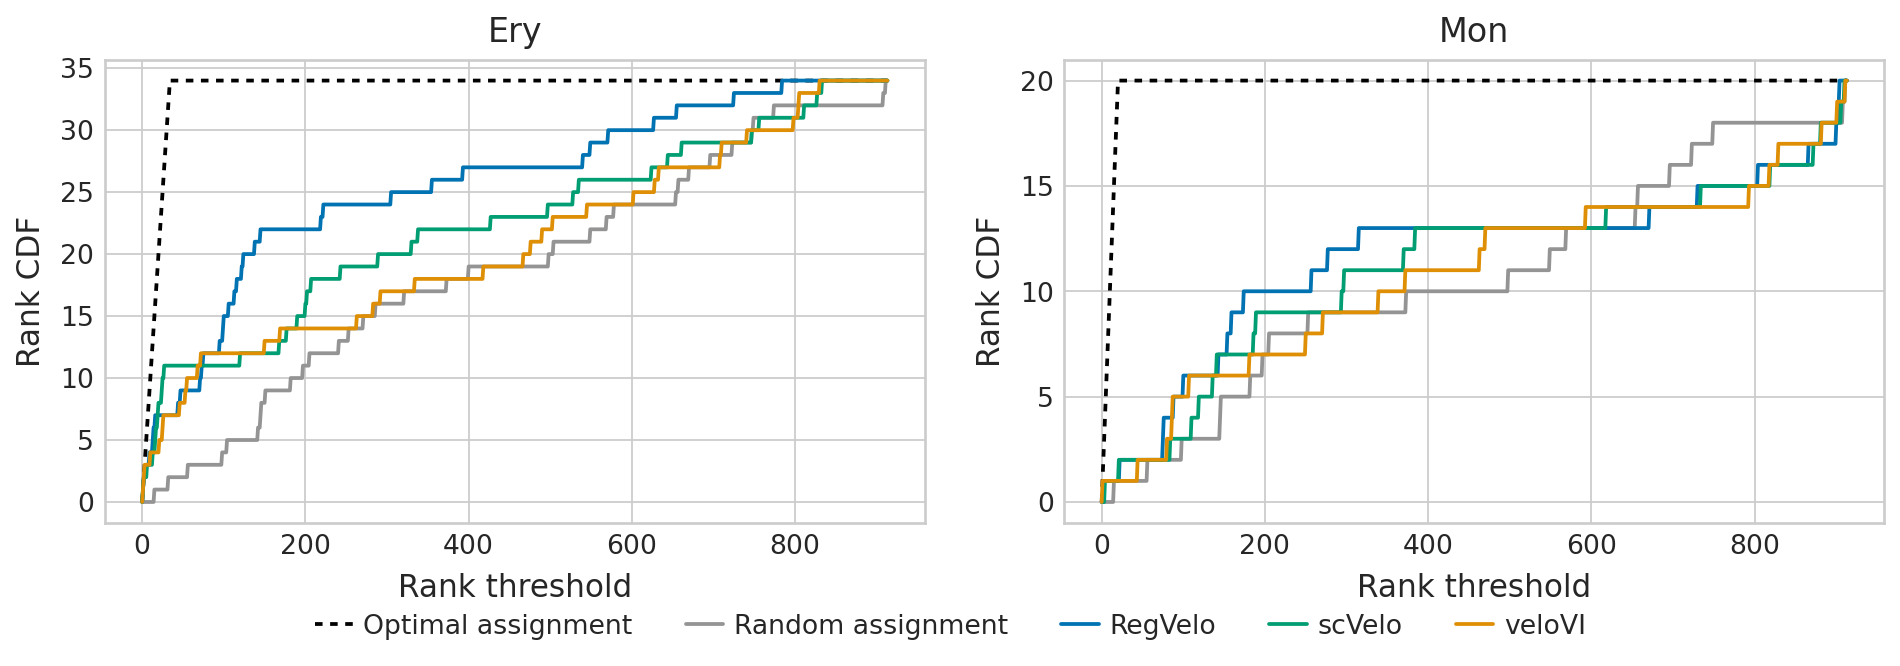

In [59]:
plot_gene_ranking(
    rank_threshold=dfs, methods=methods, palette=pal, path=FIG_DIR / "hematopoiesis" / "Gene Ranking.svg", format="svg"
)

In [60]:
optimal_aucs = {}

for terminal_state in TERMINAL_STATES:
    if "Run" in gene_ranks[terminal_state].columns:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby(["Algorithm"]).size() / gene_ranks[
            terminal_state
        ].groupby(["Algorithm"]).apply(lambda x: len(x["Run"].unique()))
    else:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby("Algorithm").size()
    optimal_aucs[terminal_state] = get_optimal_auc(optimal_aucs[terminal_state])

In [61]:
_, auc_rel_df = get_aucs(gene_ranking_dfs=dfs, optimal_aucs=optimal_aucs, methods=methods)
auc_rel_df

,Ery,Mon
Random assignment,0.565427,0.535434
scVelo,0.672948,0.563571
Optimal assignment,0.998329,0.998342
veloVI,0.623562,0.541294
RegVelo,0.772931,0.588668


## Run models for 3 times to test cell fate reproducibility

In [62]:
for nrun in range(3):
    REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
    rgv_model = REGVELOVI(reg_bdata, W=W.T, regulators=TF, lam2=1)
    rgv_model.train()
    adata_target_repeat = add_regvelo_outputs_to_adata(reg_bdata, rgv_model)

    vae = VELOVI(adata_vi)
    vae.train()
    add_outputs_to_adata(adata_vi, vae)

    path = DATA_DIR / "hematopoiesis"
    rgv_model_name = "rgv_adata_runs_" + str(nrun) + ".h5ad"
    adata_target_repeat.write_h5ad(path / rgv_model_name)
    vi_model_name = "vi_adata_runs_" + str(nrun) + ".h5ad"
    adata_vi.write_h5ad(path / vi_model_name)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 761/1500:  51%|█████     | 761/1500 [04:22<04:15,  2.90it/s, loss=-170, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -302.023. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 330/500:  66%|██████▌   | 330/500 [00:42<00:21,  7.84it/s, loss=-272, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -257.845. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1119/1500:  75%|███████▍  | 1119/1500 [06:25<02:11,  2.90it/s, loss=-189, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -315.938. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 379/500:  76%|███████▌  | 379/500 [00:47<00:15,  7.94it/s, loss=-271, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -258.018. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 924/1500:  62%|██████▏   | 924/1500 [05:14<03:16,  2.93it/s, loss=-171, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -302.295. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 327/500:  65%|██████▌   | 327/500 [00:41<00:21,  7.97it/s, loss=-271, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -258.292. Signaling Trainer to stop.


## Save datasets

In [63]:
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae_raw)
adata_target_regularized = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

In [64]:
if SAVE_DATASETS:
    path = DATA_DIR / "hematopoiesis"
    adata_target.write_h5ad(path / "rgv_adata.h5ad")
    adata_target_regularized.write_h5ad(path / "rgv_adata_re.h5ad")
    adata_vi.write_h5ad(path / "vi_adata.h5ad")
    adata_scv.write_h5ad(path / "scv_adata.h5ad")